In [21]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
class RNN:
	def __init__(self, input_size, hidden_size, output_size, learning_rate=0.001):
		self.hidden_size = hidden_size
		self.learning_rate = learning_rate
		
		# W: input -> hidden
		self.W = np.random.randn(hidden_size, input_size) * 0.01
		# U: hidden -> hidden (recurrent connection)
		self.U = np.random.randn(hidden_size, hidden_size) * 0.01
		# V: hidden -> output
		self.V = np.random.randn(output_size, hidden_size) * 0.01
		
		# Biases
		self.b_h = np.zeros((hidden_size, 1))
		self.b_y = np.zeros((output_size, 1))

	def _tanh(self, x):
		return np.tanh(x)

	def _softmax(self, x):
		e_x = np.exp(x - np.max(x)) 
		return e_x / np.sum(e_x, axis=0)

	def forward(self, inputs):
		xs, hs, ys, ps = {}, {}, {}, {}
		
		# h[-1] represents h_{t-1} at t=0 (the initial hidden state)
		hs[-1] = np.zeros((self.hidden_size, 1))
		
		for t, x in enumerate(inputs):
			# Store input (ensure column vector)
			xs[t] = x.reshape(-1, 1)
			
			# Update Hidden State: h_t = tanh(U*h_{t-1} + W*x_t)
			hs[t] = self._tanh(np.dot(self.U, hs[t-1]) + np.dot(self.W, xs[t]) + self.b_h)
			
			# Generate Output: y_t = softmax(V*h_t)
			ys[t] = np.dot(self.V, hs[t]) + self.b_y
			ps[t] = self._softmax(ys[t])
			
		return xs, hs, ps

	def loss(self, ps, targets):
		loss = 0
		for t, target in enumerate(targets):
			correct_class_prob = ps[t][target, 0]
			loss += -np.log(correct_class_prob)
		return loss / len(targets)

	def train_step(self, inputs, targets):
		xs, hs, ps = self.forward(inputs)
		
		# Gradients
		dW = np.zeros_like(self.W)
		dU = np.zeros_like(self.U)
		dV = np.zeros_like(self.V)
		
		db_h = np.zeros_like(self.b_h)
		db_y = np.zeros_like(self.b_y)
		
		dh_next = np.zeros_like(hs[0])
		
		# BPTT
		for t in reversed(range(len(inputs))):
			# Derivative of Cross Entropy + Softmax is simply (probs - target)
			dy = np.copy(ps[t])
			dy[targets[t]] -= 1
			
			# Update V gradients (Output weights)
			dV += np.dot(dy, hs[t].T)
			db_y += dy
			
			# h gradient flows from Output (V) AND from Next Hidden State (dh_next)
			dh = np.dot(self.V.T, dy) + dh_next
			
			# Backprop through Tanh activation
			# Derivative of tanh(x) is (1 - tanh(x)^2)
			dtanh = (1 - hs[t] * hs[t]) * dh 
			
			# Update U and W gradients (Shared weights) 
			dW += np.dot(dtanh, xs[t].T)
			dU += np.dot(dtanh, hs[t-1].T)
			db_h += dtanh
			
			# Compute gradient for the next iteration (which is the previous time step t-1)
			dh_next = np.dot(self.U.T, dtanh)
			
		# SGD Update with clipping
		for dparam in [dW, dU, dV, db_h, db_y]:
			np.clip(dparam, -5, 5, out=dparam)
			
		# Update weights
		self.W -= self.learning_rate * dW
		self.U -= self.learning_rate * dU
		self.V -= self.learning_rate * dV
		self.b_h -= self.learning_rate * db_h
		self.b_y -= self.learning_rate * db_y
		
		return self.loss(ps, targets)

### Testing with names auto-completing

In [25]:
with open('../datasets/names.txt', 'r') as f:
	names = f.read().splitlines()

# Build vocabulary
chars = sorted(list(set(''.join(names) + '.')))
data_size, vocab_size = len(names), len(chars)

print(f'Dataset: {data_size} names')
print(f'Vocabulary ({vocab_size} chars): {"".join(chars)}')

# Mappings
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

def get_one_hot(idx, size):
	vec = np.zeros((size, 1))
	vec[idx] = 1
	return vec

def sample(rnn, seed_ix, n):
	h = np.zeros((rnn.hidden_size, 1))
	
	x = get_one_hot(seed_ix, vocab_size)
	
	ixes = []
	
	for t in range(n):
		# h_t = tanh(U * h_{t-1} + W * x_t + b_h)
		h = np.tanh(np.dot(rnn.U, h) + np.dot(rnn.W, x) + rnn.b_h)
		
		# y = V * h_t + b_y
		y = np.dot(rnn.V, h) + rnn.b_y
		
		# Softmax
		p = np.exp(y) / np.sum(np.exp(y))
		
		# Sample the next character index based on the probability distribution
		ix = np.random.choice(range(vocab_size), p=p.ravel())
		
		# Prepare input for the next time step
		x = get_one_hot(ix, vocab_size)
		
		ixes.append(ix)
		
		# If we picked the "end token" (which is '.'), stop early
		if ix == char_to_ix['.']:
			break
			
	return ixes

hidden_size = 500
learning_rate = 0.005
iter_limit = 10000

losses = []

rnn = RNN(vocab_size, hidden_size, vocab_size, learning_rate)

n, p = 0, 0
smooth_loss = -np.log(1.0/vocab_size) * 7

print(f"Training for {iter_limit} iterations...")

while n < iter_limit:
	if p + 1 >= len(names) or n == 0: 
		p = 0
		random.shuffle(names)
		
	# Input: "." + "name"
	# Target: "name" + "."
	name = names[p]
	word_inputs = ['.'] + [ch for ch in name]
	word_targets = [ch for ch in name] + ['.']
	
	# Encode Inputs as list of One-Hot vectors
	inputs = [get_one_hot(char_to_ix[ch], vocab_size) for ch in word_inputs]
	
	# Encode Targets as list of Integers (indices)
	targets = [char_to_ix[ch] for ch in word_targets]

	# BPTT Training
	loss = rnn.train_step(inputs, targets)
	losses.append(loss)
	
	smooth_loss = smooth_loss * 0.999 + loss * 0.001
	
	if n % 2000 == 0:
		print(f'iter {n}, loss: {smooth_loss:.4f}') 
		
		# Sample a name starting with the '.' token
		start_ix = char_to_ix['.']
		sample_ix = sample(rnn, start_ix, 20)
		txt = ''.join(ix_to_char[ix] for ix in sample_ix)
		print(f'----\n Sampled: {txt[:-1] if txt.endswith(".") else txt}\n----')

	p += 1
	n += 1

Dataset: 32033 names
Vocabulary (27 chars): .abcdefghijklmnopqrstuvwxyz
Training for 10000 iterations...
iter 0, loss: 23.0511
----
 Sampled: hwnfsh
----
iter 2000, loss: 5.3966
----
 Sampled: aria
----
iter 4000, loss: 2.8581
----
 Sampled: aropnhort
----
iter 6000, loss: 2.4533
----
 Sampled: lyas
----
iter 8000, loss: 2.3659
----
 Sampled: ylam
----


Seed  | Generated Name
-------------------------
A     | Axl
B     | Bxirl
C     | Cenvya
D     | Dlelyn


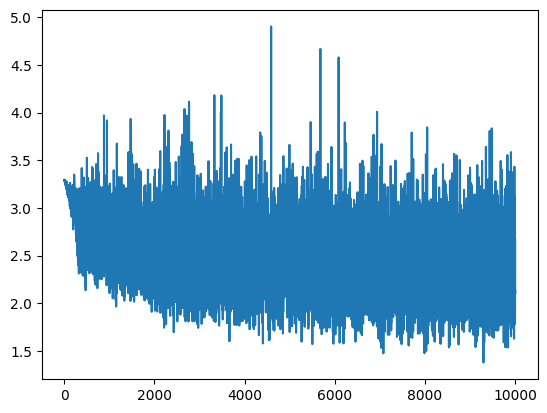

In [27]:
def generate_names(rnn, start_letters):
    print(f"{'Seed':<5} | {'Generated Name'}")
    print("-" * 25)
    
    for char in start_letters:
        char_lower = char.lower()
            
        seed_ix = char_to_ix[char_lower]
        
        # Generate up to 20 characters
        generated_indices = sample(rnn, seed_ix, 20)
        
        txt = ''.join(ix_to_char[ix] for ix in generated_indices)
        
        full_name = char.upper() + txt.replace('.', '')
        
        print(f"{char:<5} | {full_name}")

starting_letters = ['A', 'B', 'C', 'D']
generate_names(rnn, starting_letters)

plt.plot(losses)
plt.show()